<a href="https://colab.research.google.com/github/herlinalim-ugm/Machine-Translation/blob/main/NMT_Dengan_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# =========================================
# 🚀 NMT Indonesia → Jawa (RNN Seq2Seq) + Attention
# =========================================

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# ------------------------------
# 1️⃣ Load Dataset
# ------------------------------
train_path = "/content/drive/MyDrive/Colab Notebooks/NMT/train.csv"
valid_path = "/content/drive/MyDrive/Colab Notebooks/NMT/valid.csv"
test_path  = "/content/drive/MyDrive/Colab Notebooks/NMT/test.csv"

train_df = pd.read_csv(train_path)
valid_df = pd.read_csv(valid_path)
test_df  = pd.read_csv(test_path)

print(f"Jumlah data train: {len(train_df)}, valid: {len(valid_df)}, test: {len(test_df)}")

# ------------------------------
# 2️⃣ Persiapan Data
# ------------------------------
input_texts_train = train_df["indonesian"].astype(str).tolist()
target_texts_train = ["<start> " + t + " <end>" for t in train_df["javanese"].astype(str).tolist()]

input_texts_val = valid_df["indonesian"].astype(str).tolist()
target_texts_val = ["<start> " + t + " <end>" for t in valid_df["javanese"].astype(str).tolist()]

input_texts_test = test_df["indonesian"].astype(str).tolist()
target_texts_test = ["<start> " + t + " <end>" for t in test_df["javanese"].astype(str).tolist()]

# Tokenizer
tokenizer_src = Tokenizer(filters='')
tokenizer_src.fit_on_texts(input_texts_train)
tokenizer_tgt = Tokenizer(filters='')
tokenizer_tgt.fit_on_texts(target_texts_train)

input_train = tokenizer_src.texts_to_sequences(input_texts_train)
target_train = tokenizer_tgt.texts_to_sequences(target_texts_train)
input_val = tokenizer_src.texts_to_sequences(input_texts_val)
target_val = tokenizer_tgt.texts_to_sequences(target_texts_val)
input_test = tokenizer_src.texts_to_sequences(input_texts_test)
target_test = tokenizer_tgt.texts_to_sequences(target_texts_test)

max_encoder_seq_length = max([len(txt) for txt in input_train])
max_decoder_seq_length = max([len(txt) for txt in target_train])

encoder_input_train = pad_sequences(input_train, maxlen=max_encoder_seq_length, padding='post')
decoder_input_train = pad_sequences(target_train, maxlen=max_decoder_seq_length, padding='post')
encoder_input_val = pad_sequences(input_val, maxlen=max_encoder_seq_length, padding='post')
decoder_input_val = pad_sequences(target_val, maxlen=max_decoder_seq_length, padding='post')
encoder_input_test = pad_sequences(input_test, maxlen=max_encoder_seq_length, padding='post')
decoder_input_test = pad_sequences(target_test, maxlen=max_decoder_seq_length, padding='post')

num_encoder_tokens = len(tokenizer_src.word_index) + 1
num_decoder_tokens = len(tokenizer_tgt.word_index) + 1

Jumlah data train: 500, valid: 100, test: 400


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │    881,664 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │    942,080 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 256) │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, None, 256) │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, None,     │     82,176 │ dropout[0][0],    │
│                     │ 64), (None, 64),  │            │ not_equal[0][0]   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │     82,176 │ dropout_1[0][0],  │
│                     │ 64), (None, 64),  │            │ lstm[0][1],       │
│                     │ (None, 64)]       │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bahdanau_attention  │ [(None, None,     │      8,385 │ lstm_1[0][0],     │
│ (BahdanauAttention) │ 64), (None, None, │            │ lstm[0][0]        │
│                     │ None)]            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 128) │          0 │ bahdanau_attenti… │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None,      │    474,720 │ concatenate[0][0] │
│                     │ 3680)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,471,201 (9.43 MB)

 Trainable params: 2,471,201 (9.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3222 - loss: 8.1333
Epoch 1: val_loss improved from inf to 7.74398, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3595 - loss: 8.1185 - val_accuracy: 0.7648 - val_loss: 7.7440 - learning_rate: 0.0010
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6829 - loss: 7.7273
Epoch 2: val_loss improved from 7.74398 to 7.25355, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6838 - loss: 7.7115 - val_accuracy: 0.7648 - val_loss: 7.2535 - learning_rate: 0.0010
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6842 - loss: 7.2616
Epoch 3: val_loss improved from 7.25355 to 6.53319, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6848 - loss: 7.2392 - val_accuracy: 0.7648 - val_loss: 6.5332 - learning_rate: 0.0010
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6759 - loss: 6.5805
Epoch 4: val_loss improved from 6.53319 to 5.55997, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6782 - loss: 6.5442 - val_accuracy: 0.7648 - val_loss: 5.5600 - learning_rate: 0.0010
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6847 - loss: 5.6409
Epoch 5: val_loss improved from 5.55997 to 4.52644, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6852 - loss: 5.6022 - val_accuracy: 0.7648 - val_loss: 4.5264 - learning_rate: 0.0010
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6846 - loss: 4.6649
Epoch 6: val_loss improved from 4.52644 to 3.54903, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6852 - loss: 4.6298 - val_accuracy: 0.7648 - val_loss: 3.5490 - learning_rate: 0.0010
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6825 - loss: 3.7976
Epoch 7: val_loss improved from 3.54903 to 2.72225, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6835 - loss: 3.7638 - val_accuracy: 0.7649 - val_loss: 2.7222 - learning_rate: 0.0010
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6807 - loss: 3.1030
Epoch 8: val_loss improved from 2.72225 to 2.16817, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6821 - loss: 3.0755 - val_accuracy: 0.7649 - val_loss: 2.1682 - learning_rate: 0.0010
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6858 - loss: 2.6577
Epoch 9: val_loss improved from 2.16817 to 1.90018, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6862 - loss: 2.6454 - val_accuracy: 0.7648 - val_loss: 1.9002 - learning_rate: 0.0010
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6944 - loss: 2.4161
Epoch 10: val_loss improved from 1.90018 to 1.77481, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.6930 - loss: 2.4224 - val_accuracy: 0.7648 - val_loss: 1.7748 - learning_rate: 0.0010
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6836 - loss: 2.4170
Epoch 11: val_loss improved from 1.77481 to 1.69200, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6843 - loss: 2.4083 - val_accuracy: 0.7648 - val_loss: 1.6920 - learning_rate: 0.0010
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6892 - loss: 2.3056
Epoch 12: val_loss improved from 1.69200 to 1.63480, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6888 - loss: 2.3056 - val_accuracy: 0.7648 - val_loss: 1.6348 - learning_rate: 0.0010
Epoch 13/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6809 - loss: 2.3120
Epoch 13: val_loss improved from 1.63480 to 1.60733, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6822 - loss: 2.3007 - val_accuracy: 0.7648 - val_loss: 1.6073 - learning_rate: 0.0010
Epoch 14/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6841 - loss: 2.2484
Epoch 14: val_loss improved from 1.60733 to 1.59421, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6848 - loss: 2.2443 - val_accuracy: 0.7648 - val_loss: 1.5942 - learning_rate: 0.0010
Epoch 15/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6925 - loss: 2.1794
Epoch 15: val_loss improved from 1.59421 to 1.58139, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6915 - loss: 2.1863 - val_accuracy: 0.7648 - val_loss: 1.5814 - learning_rate: 0.0010
Epoch 16/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6827 - loss: 2.2452
Epoch 16: val_loss improved from 1.58139 to 1.57000, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6838 - loss: 2.2369 - val_accuracy: 0.7660 - val_loss: 1.5700 - learning_rate: 0.0010
Epoch 17/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6929 - loss: 2.1668
Epoch 17: val_loss improved from 1.57000 to 1.56133, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6921 - loss: 2.1724 - val_accuracy: 0.7670 - val_loss: 1.5613 - learning_rate: 0.0010
Epoch 18/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6941 - loss: 2.1479
Epoch 18: val_loss improved from 1.56133 to 1.55456, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6929 - loss: 2.1559 - val_accuracy: 0.7690 - val_loss: 1.5546 - learning_rate: 0.0010
Epoch 19/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6939 - loss: 2.1470
Epoch 19: val_loss improved from 1.55456 to 1.54929, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6929 - loss: 2.1541 - val_accuracy: 0.7692 - val_loss: 1.5493 - learning_rate: 0.0010
Epoch 20/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6912 - loss: 2.1624
Epoch 20: val_loss improved from 1.54929 to 1.54522, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6907 - loss: 2.1657 - val_accuracy: 0.7687 - val_loss: 1.5452 - learning_rate: 0.0010
Epoch 21/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6904 - loss: 2.1643
Epoch 21: val_loss improved from 1.54522 to 1.54203, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6900 - loss: 2.1665 - val_accuracy: 0.7686 - val_loss: 1.5420 - learning_rate: 0.0010
Epoch 22/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6986 - loss: 2.0997
Epoch 22: val_loss improved from 1.54203 to 1.53928, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6965 - loss: 2.1142 - val_accuracy: 0.7686 - val_loss: 1.5393 - learning_rate: 0.0010
Epoch 23/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6950 - loss: 2.1297
Epoch 23: val_loss improved from 1.53928 to 1.53699, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6937 - loss: 2.1378 - val_accuracy: 0.7694 - val_loss: 1.5370 - learning_rate: 0.0010
Epoch 24/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6850 - loss: 2.1970
Epoch 24: val_loss improved from 1.53699 to 1.53519, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6860 - loss: 2.1911 - val_accuracy: 0.7706 - val_loss: 1.5352 - learning_rate: 0.0010
Epoch 25/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6861 - loss: 2.1932
Epoch 25: val_loss improved from 1.53519 to 1.53333, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6871 - loss: 2.1876 - val_accuracy: 0.7723 - val_loss: 1.5333 - learning_rate: 0.0010
Epoch 26/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6943 - loss: 2.1414
Epoch 26: val_loss improved from 1.53333 to 1.53169, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6939 - loss: 2.1457 - val_accuracy: 0.7742 - val_loss: 1.5317 - learning_rate: 0.0010
Epoch 27/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6852 - loss: 2.2068
Epoch 27: val_loss improved from 1.53169 to 1.53017, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6868 - loss: 2.1976 - val_accuracy: 0.7752 - val_loss: 1.5302 - learning_rate: 0.0010
Epoch 28/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6879 - loss: 2.1946
Epoch 28: val_loss improved from 1.53017 to 1.52900, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6890 - loss: 2.1874 - val_accuracy: 0.7755 - val_loss: 1.5290 - learning_rate: 0.0010
Epoch 29/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6882 - loss: 2.1919
Epoch 29: val_loss improved from 1.52900 to 1.52832, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6893 - loss: 2.1848 - val_accuracy: 0.7764 - val_loss: 1.5283 - learning_rate: 0.0010
Epoch 30/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7008 - loss: 2.1130
Epoch 30: val_loss improved from 1.52832 to 1.52753, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.6995 - loss: 2.1212 - val_accuracy: 0.7770 - val_loss: 1.5275 - learning_rate: 0.0010
Epoch 31/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7013 - loss: 2.1032
Epoch 31: val_loss improved from 1.52753 to 1.52657, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7000 - loss: 2.1129 - val_accuracy: 0.7771 - val_loss: 1.5266 - learning_rate: 0.0010
Epoch 32/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6981 - loss: 2.1295
Epoch 32: val_loss improved from 1.52657 to 1.52585, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6975 - loss: 2.1336 - val_accuracy: 0.7773 - val_loss: 1.5258 - learning_rate: 0.0010
Epoch 33/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7033 - loss: 2.0901
Epoch 33: val_loss improved from 1.52585 to 1.52508, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7017 - loss: 2.1016 - val_accuracy: 0.7782 - val_loss: 1.5251 - learning_rate: 0.0010
Epoch 34/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6988 - loss: 2.1236
Epoch 34: val_loss improved from 1.52508 to 1.52430, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6982 - loss: 2.1279 - val_accuracy: 0.7782 - val_loss: 1.5243 - learning_rate: 0.0010
Epoch 35/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6991 - loss: 2.1271
Epoch 35: val_loss improved from 1.52430 to 1.52369, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6986 - loss: 2.1303 - val_accuracy: 0.7782 - val_loss: 1.5237 - learning_rate: 0.0010
Epoch 36/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6925 - loss: 2.1692
Epoch 36: val_loss improved from 1.52369 to 1.52292, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6934 - loss: 2.1634 - val_accuracy: 0.7787 - val_loss: 1.5229 - learning_rate: 0.0010
Epoch 37/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6911 - loss: 2.1718
Epoch 37: val_loss improved from 1.52292 to 1.52205, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6924 - loss: 2.1650 - val_accuracy: 0.7788 - val_loss: 1.5220 - learning_rate: 0.0010
Epoch 38/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6991 - loss: 2.1286
Epoch 38: val_loss improved from 1.52205 to 1.52146, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6989 - loss: 2.1300 - val_accuracy: 0.7787 - val_loss: 1.5215 - learning_rate: 0.0010
Epoch 39/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6891 - loss: 2.1946
Epoch 39: val_loss improved from 1.52146 to 1.52067, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6910 - loss: 2.1823 - val_accuracy: 0.7790 - val_loss: 1.5207 - learning_rate: 0.0010
Epoch 40/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6940 - loss: 2.1593
Epoch 40: val_loss improved from 1.52067 to 1.51990, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6950 - loss: 2.1535 - val_accuracy: 0.7792 - val_loss: 1.5199 - learning_rate: 0.0010
Epoch 41/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7005 - loss: 2.1152
Epoch 41: val_loss improved from 1.51990 to 1.51913, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7003 - loss: 2.1176 - val_accuracy: 0.7796 - val_loss: 1.5191 - learning_rate: 0.0010
Epoch 42/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7037 - loss: 2.0982
Epoch 42: val_loss improved from 1.51913 to 1.51843, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.7030 - loss: 2.1034 - val_accuracy: 0.7803 - val_loss: 1.5184 - learning_rate: 0.0010
Epoch 43/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7098 - loss: 2.0607
Epoch 43: val_loss improved from 1.51843 to 1.51796, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7080 - loss: 2.0729 - val_accuracy: 0.7806 - val_loss: 1.5180 - learning_rate: 0.0010
Epoch 44/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7037 - loss: 2.1015
Epoch 44: val_loss improved from 1.51796 to 1.51733, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.7032 - loss: 2.1049 - val_accuracy: 0.7806 - val_loss: 1.5173 - learning_rate: 0.0010
Epoch 45/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6999 - loss: 2.1249
Epoch 45: val_loss improved from 1.51733 to 1.51668, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7002 - loss: 2.1230 - val_accuracy: 0.7812 - val_loss: 1.5167 - learning_rate: 0.0010
Epoch 46/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7023 - loss: 2.1079
Epoch 46: val_loss improved from 1.51668 to 1.51608, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7022 - loss: 2.1088 - val_accuracy: 0.7814 - val_loss: 1.5161 - learning_rate: 0.0010
Epoch 47/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6969 - loss: 2.1493
Epoch 47: val_loss improved from 1.51608 to 1.51561, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.6980 - loss: 2.1412 - val_accuracy: 0.7816 - val_loss: 1.5156 - learning_rate: 0.0010
Epoch 48/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7066 - loss: 2.0776
Epoch 48: val_loss improved from 1.51561 to 1.51535, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7059 - loss: 2.0832 - val_accuracy: 0.7813 - val_loss: 1.5154 - learning_rate: 0.0010
Epoch 49/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7092 - loss: 2.0660
Epoch 49: val_loss improved from 1.51535 to 1.51502, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7080 - loss: 2.0731 - val_accuracy: 0.7816 - val_loss: 1.5150 - learning_rate: 0.0010
Epoch 50/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7021 - loss: 2.1113
Epoch 50: val_loss improved from 1.51502 to 1.51501, saving model to best_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7025 - loss: 2.1086 - val_accuracy: 0.7819 - val_loss: 1.5150 - learning_rate: 0.0010
Epoch 51/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6993 - loss: 2.1202
Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 51: val_loss did not improve from 1.51501
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7004 - loss: 2.1150 - val_accuracy: 0.7822 - val_loss: 1.5156 - learning_rate: 0.0010
Epoch 52/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6976 - loss: 2.1497
Epoch 52: val_loss did not improve from 1.51501
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6991 - loss: 2.1379 - val_accuracy: 0.7822 - val_loss: 1.5159 - learning_rate: 5.0000e-04
Epoch 53/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6970 - loss: 2.1564
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 53: val_loss did not improve from 1.51501
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step

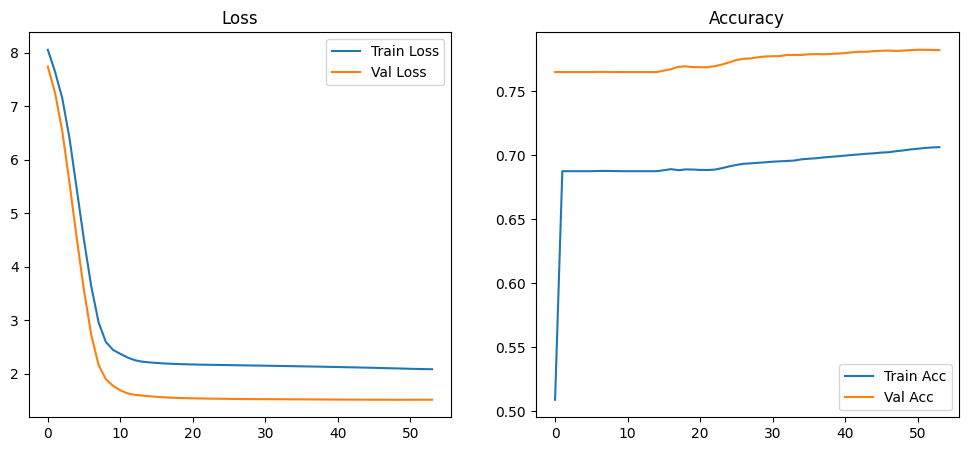

In [5]:
# =========================================
# 3️⃣ Hyperparameters #
# =========================================
embedding_dim = 256
latent_dim = 64
batch_size = 128
epochs = 300
learning_rate = 0.001
dropout_rate = 0.5

# =========================================
# 4️⃣ Model Encoder-Decoder + Bahdanau Attention
# =========================================

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

# 🔹 Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(num_encoder_tokens, embedding_dim, mask_zero=True)(encoder_inputs)
enc_emb = Dropout(dropout_rate)(enc_emb)
encoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# 🔹 Bahdanau Attention Layer (vectorized)
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values, mask=None):
        w1 = self.W1(values)
        w2 = self.W2(query)

        # expand untuk broadcast: tambahkan dimensi waktu
        w1_exp = tf.expand_dims(w1, 1)
        w2_exp = tf.expand_dims(w2, 2)

        score = self.V(tf.nn.tanh(w1_exp + w2_exp))
        score = tf.squeeze(score, axis=-1)

        # Terapkan mask
        if mask is not None:
            # Mask encoder biasanya dari embedding encoder (True=valid)
            enc_mask = mask[1] if isinstance(mask, list) else mask
            if enc_mask is not None:
                enc_mask = tf.cast(enc_mask, tf.float32)
                enc_mask = tf.expand_dims(enc_mask, 1)
                score = score * enc_mask + ((1.0 - enc_mask) * -1e9)

        attention_weights = tf.nn.softmax(score, axis=-1)  # (batch, targ_time, src_time)

        # Hitung context vector
        context = tf.matmul(attention_weights, values)  # (batch, targ_time, latent_dim)
        return context, attention_weights

attention = BahdanauAttention(latent_dim)

# 🔹 Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(num_decoder_tokens, embedding_dim, mask_zero=True)(decoder_inputs)
dec_emb = Dropout(dropout_rate)(dec_emb)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 🔹 Hitung attention (vectorized untuk semua langkah waktu)
context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)

# 🔹 Gabungkan context vector + output decoder
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_outputs])

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

# 🔹 Final model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

# =========================================
# 5️⃣ Compile & Training
# =========================================

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# =========================================
# 🔁 Callbacks
# =========================================
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Turunkan learning rate bila val_loss tidak membaik
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-5
)

# Hentikan training jika val_loss stagnan
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

# Simpan model terbaik berdasarkan val_loss
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    [encoder_input_train, decoder_input_train[:, :-1]],
    np.expand_dims(decoder_input_train[:, 1:], -1),
    batch_size=batch_size,
    epochs=300,
    validation_data=(
        [encoder_input_val, decoder_input_val[:, :-1]],
        np.expand_dims(decoder_input_val[:, 1:], -1)
    ),
    callbacks=[reduce_lr, early_stop, checkpoint],
    verbose=1
)

# ------------------------------
# 6️⃣ Plot Training & Validation
# ------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


✅ Inference encoder & decoder siap (final).
Mulai inference pada subset 5 sampel (cepat)...

--- Sampel 1 ---
Input: Dekat dengan hotel saya menginap, hanya ditempuh jalan kaki, di sini banyak sekali pilihan makanannya, tempat yang luas, dan menyenangkan
Ref  : Cepak saka hotelku nginep, namung digawa mlaku, ing kene akeh tenan pilian panganane, panggonane sing amba, lan nyenengake
Pred : aku aku aku sing sing sing sing sing sing sing sing sing sing sing
BLEU : 0.0107

--- Sampel 2 ---
Input: Iya benar, dia sedang jaga warung.
Ref  : Iya bener, deknen lagi jaga warung.
Pred :                                        
BLEU : 0.0000

--- Sampel 3 ---
Input: Kangkungnya lumayan tapi kepiting saus padangnya mengecewakan kami dikasih kepiting yang kopong akhir kami tidak makan keptingnya dan dikembalikan.
Ref  : Kangkunge lumayan nanging yuyu saus padange nguciwakake dhewe dikei yuyu sing kopong akhir dhewe ora mangan yuyune lan dibalekake.
Pred : aku aku aku sing sing sing sing sing sing sin

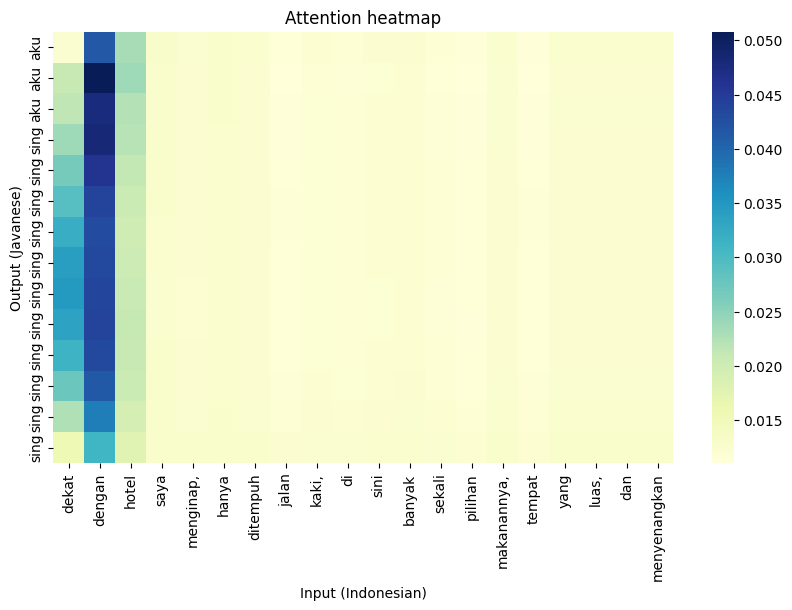

In [6]:
# =========================
# Inference + BLEU + Heatmap
# =========================
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.get_logger().setLevel('ERROR')

# -------------------------
# 1) Siapkan encoder_model
# -------------------------
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# -------------------------
# 2) Ambil layer-layer yang diperlukan dari model training
#    ambil decoder embedding robust: semua embedding lalu ambil yang terakhir
# -------------------------
emb_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Embedding)]
if len(emb_layers) == 0:
    raise RuntimeError("Tidak menemukan layer Embedding pada model.")
dec_emb_layer = emb_layers[-1]

# ambil decoder LSTM, attention (instance 'attention' dibuat di training), dan decoder_dense
# jika variabel decoder_lstm/decoder_dense tersedia, gunakan; kalau tidak, ambil dari model.layers
try:
    dec_lstm_layer = decoder_lstm
    dec_dense_layer = decoder_dense
    attn_layer = attention
except NameError:
    # fallback: ambil berdasarkan tipe
    dec_lstm_layer = [l for l in model.layers if isinstance(l, tf.keras.layers.LSTM)][-1]
    dec_dense_layer = [l for l in model.layers if isinstance(l, tf.keras.layers.Dense)][-1]
    # gunakan instance attention dari variabel 'attention' jika ada, else find by class name
    attn_layer = None
    for l in model.layers:
        if l.__class__.__name__.lower().startswith('bahdanauattention') or 'attention' in l.name:
            attn_layer = l
            break
    if attn_layer is None:
        attn_layer = attention  # try global

# -------------------------
# 3) Bangun decoder_model (1 step)
# -------------------------
decoder_state_input_h = Input(shape=(latent_dim,), name='dec_state_h_in')
decoder_state_input_c = Input(shape=(latent_dim,), name='dec_state_c_in')
encoder_outputs_inf = Input(shape=(None, latent_dim), name='enc_outs_inf')
decoder_input_single = Input(shape=(1,), name='dec_input_single')

# embedding 1 token
dec_emb_single = dec_emb_layer(decoder_input_single)

# 1-step LSTM
decoder_output_single, state_h_new, state_c_new = dec_lstm_layer(
    dec_emb_single, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# attention: query = decoder_output_single, values = encoder_outputs_inf
context_vector, attn_weights = attn_layer(decoder_output_single, encoder_outputs_inf)

# concat context + decoder_output_single (axis last)
decoder_combined_single = Concatenate(axis=-1)([context_vector, decoder_output_single])

# dense -> pred
decoder_pred_single = dec_dense_layer(decoder_combined_single)

decoder_model = Model(
    [decoder_input_single, decoder_state_input_h, decoder_state_input_c, encoder_outputs_inf],
    [decoder_pred_single, state_h_new, state_c_new, attn_weights]
)

print("✅ Inference encoder & decoder siap (final).")

# -------------------------
# 4) Utility: reverse index mapping safe
# -------------------------
# tokenizer_tgt.word_index: word -> index
reverse_target_index = {idx:word for word, idx in tokenizer_tgt.word_index.items()}
reverse_target_index[0] = ''

# safe start token (fallback ke 1 jika tidak ada)
start_token = tokenizer_tgt.word_index.get('<start>', 1)

# -------------------------
# 5) Fungsi decode (aman, dengan batas max_len)
# -------------------------
def decode_sequence_with_attention(input_seq, max_len=None):
    if max_len is None:
        max_len = min(40, max_decoder_seq_length)  # batas default untuk cepat

    enc_outs, state_h_val, state_c_val = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.array([[start_token]])
    decoded_tokens = []
    attention_plot = []

    for t in range(max_len):
        preds, h, c, attn = decoder_model.predict([target_seq, state_h_val, state_c_val, enc_outs], verbose=0)
        # preds: (1,1,vocab)
        sampled_token_index = int(np.argmax(preds[0, -1, :]))
        sampled_word = reverse_target_index.get(sampled_token_index, None)

        # simpan attention (check shape)
        if attn is not None:
            # attn shape expected (1,1,src_time)
            try:
                attn_vec = attn[0, 0, :]
            except Exception:
                attn_vec = np.zeros((enc_outs.shape[1],), dtype=float)
        else:
            attn_vec = np.zeros((enc_outs.shape[1],), dtype=float)

        # jika token tidak diketahui atau end -> stop
        if sampled_word is None or sampled_word == '<end>':
            break

        decoded_tokens.append(sampled_word)
        attention_plot.append(attn_vec)

        # update target_seq and states
        target_seq[0, 0] = sampled_token_index
        state_h_val, state_c_val = h, c

    if len(attention_plot) == 0:
        attention_arr = np.zeros((0, enc_outs.shape[1]), dtype=float)
    else:
        attention_arr = np.vstack(attention_plot)  # shape (out_steps, src_time)

    return ' '.join(decoded_tokens), attention_arr


# -------------------------
# 6) Fungsi plotting heatmap
# -------------------------
def plot_attention_heatmap(input_sentence, predicted_sentence, attention_plot):
    input_tokens = input_sentence.lower().split()
    output_tokens = predicted_sentence.split()

    if attention_plot.size == 0 or len(output_tokens) == 0:
        print("⚠️ Tidak ada output tokens / attention untuk divisualisasikan.")
        return

    attn = attention_plot[:len(output_tokens), :len(input_tokens)]
    plt.figure(figsize=(max(8, len(input_tokens)*0.5), max(3, len(output_tokens)*0.4)))
    sns.heatmap(attn, xticklabels=input_tokens, yticklabels=output_tokens, cmap='YlGnBu')
    plt.xlabel("Input (Indonesian)")
    plt.ylabel("Output (Javanese)")
    plt.title("Attention heatmap")
    plt.show()


# -------------------------
# 7) Evaluasi cepat (subset) + pilih BLEU terbaik
# -------------------------
smooth = SmoothingFunction().method1
subset_size = min(5, len(test_df))
bleu_scores = []
translations = []
attentions = []

print(f"Mulai inference pada subset {subset_size} sampel (cepat)...")
for i in range(subset_size):
    input_sentence = test_df['indonesian'].iloc[i]
    ref_sentence = test_df['javanese'].iloc[i]

    seq = tokenizer_src.texts_to_sequences([input_sentence])
    enc_input = pad_sequences(seq, maxlen=max_encoder_seq_length, padding='post')
    pred_sentence, attn_plot = decode_sequence_with_attention(enc_input, max_len=min(40, max_decoder_seq_length))

    ref_tokens = ref_sentence.replace("<start>","").replace("<end>","").strip().split()
    pred_tokens = pred_sentence.split()

    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth) if len(pred_tokens)>0 else 0.0

    print(f"\n--- Sampel {i+1} ---")
    print("Input:", input_sentence)
    print("Ref  :", ref_sentence)
    print("Pred :", pred_sentence)
    print(f"BLEU : {bleu:.4f}")

    bleu_scores.append(bleu)
    translations.append((input_sentence, ref_sentence, pred_sentence))
    attentions.append(attn_plot)

# pilih dan tampilkan yang terbaik
if len(bleu_scores) > 0:
    best_idx = int(np.argmax(bleu_scores))
    print(f"\n>>> Menampilkan heatmap untuk kalimat dengan BLEU tertinggi (index subset: {best_idx})")
    best_input, best_ref, best_pred = translations[best_idx]
    best_attn = attentions[best_idx]
    print("BLEU terbaik:", bleu_scores[best_idx])
    plot_attention_heatmap(best_input, best_pred, best_attn)
else:
    print("Tidak ada skor BLEU (subset kosong).")


=== Evaluasi BLEU Score untuk 400 sampel test ===


100%|██████████| 400/400 [12:58<00:00,  1.95s/it]



=== Rata-rata BLEU (400 sampel): 0.0042 ===


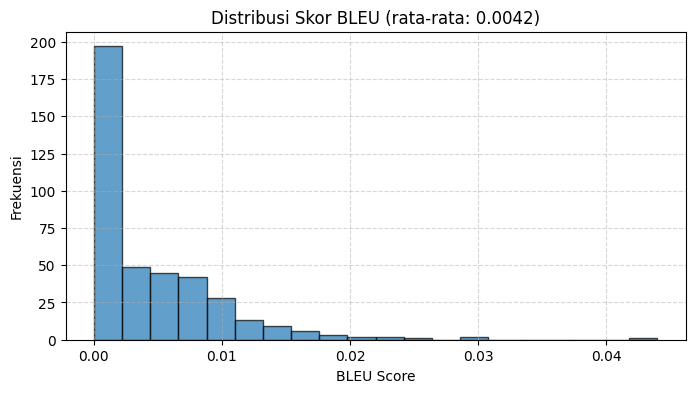

In [8]:
# =========================================
# 🔟 Evaluasi BLEU (Distribusi Seluruh Data Test)
# =========================================
from tqdm import tqdm  # progress bar
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method1
bleu_scores_all = []

num_samples_full = min(400, len(test_df))  # batasi agar cepat
print(f"\n=== Evaluasi BLEU Score untuk {num_samples_full} sampel test ===")

for i in tqdm(range(num_samples_full)):
    input_seq = encoder_input_test[i:i+1]

    # gunakan fungsi inference dengan attention
    try:
        decoded_sentence, _ = decode_sequence_with_attention(
            input_seq, max_len=min(40, max_decoder_seq_length)
        )
    except Exception as e:
        print(f"⚠️ Error di sampel {i}: {e}")
        decoded_sentence = ""

    reference = (
        target_texts_test[i]
        .replace("<start>", "")
        .replace("<end>", "")
        .strip()
        .split()
    )
    candidate = decoded_sentence.split()

    if len(candidate) == 0:
        bleu = 0.0
    else:
        bleu = sentence_bleu([reference], candidate, smoothing_function=smooth)

    bleu_scores_all.append(bleu)

# =========================================
# 🔹 Hitung rata-rata BLEU
# =========================================
avg_bleu_all = np.mean(bleu_scores_all)
print(f"\n=== Rata-rata BLEU ({num_samples_full} sampel): {avg_bleu_all:.4f} ===")

# =========================================
# 📊 Grafik Distribusi BLEU
# =========================================
plt.figure(figsize=(8, 4))
plt.hist(bleu_scores_all, bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Distribusi Skor BLEU (rata-rata: {avg_bleu_all:.4f})")
plt.xlabel("BLEU Score")
plt.ylabel("Frekuensi")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [ ]:
# =========================================
# 🔍 10️⃣ Visualisasi Heatmap untuk Kalimat dengan BLEU Tertinggi
# =========================================
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Cari index kalimat dengan BLEU tertinggi
best_idx = np.argmax(bleu_scores)

# Ambil input, referensi, dan prediksi terbaik
input_seq = encoder_input_test[best_idx:best_idx+1]
best_input = test_df['indonesian'][best_idx]
best_ref = test_df['javanese'][best_idx].replace("<start>", "").replace("<end>", "").strip().split()
best_pred = decode_sequence(input_seq).split()

# Buat matriks kesamaan sederhana (1 jika kata sama, 0 jika tidak)
heatmap_matrix = np.zeros((len(best_ref), len(best_pred)))
for i, ref_word in enumerate(best_ref):
    for j, pred_word in enumerate(best_pred):
        if ref_word == pred_word:
            heatmap_matrix[i, j] = 1

# Plot heatmap
plt.figure(figsize=(30, 18))
sns.heatmap(
    heatmap_matrix,
    annot=True,
    cmap="YlGnBu",
    xticklabels=best_pred,
    yticklabels=best_ref,
    cbar=False
)
plt.title(f"Heatmap Token Match (BLEU = {bleu_scores[best_idx]:.4f})\nInput: {best_input}")
plt.xlabel("Predicted Words")
plt.ylabel("Target Words")
plt.show()

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-2408466249.py:74: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128312 (\N{SMALL ORANGE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


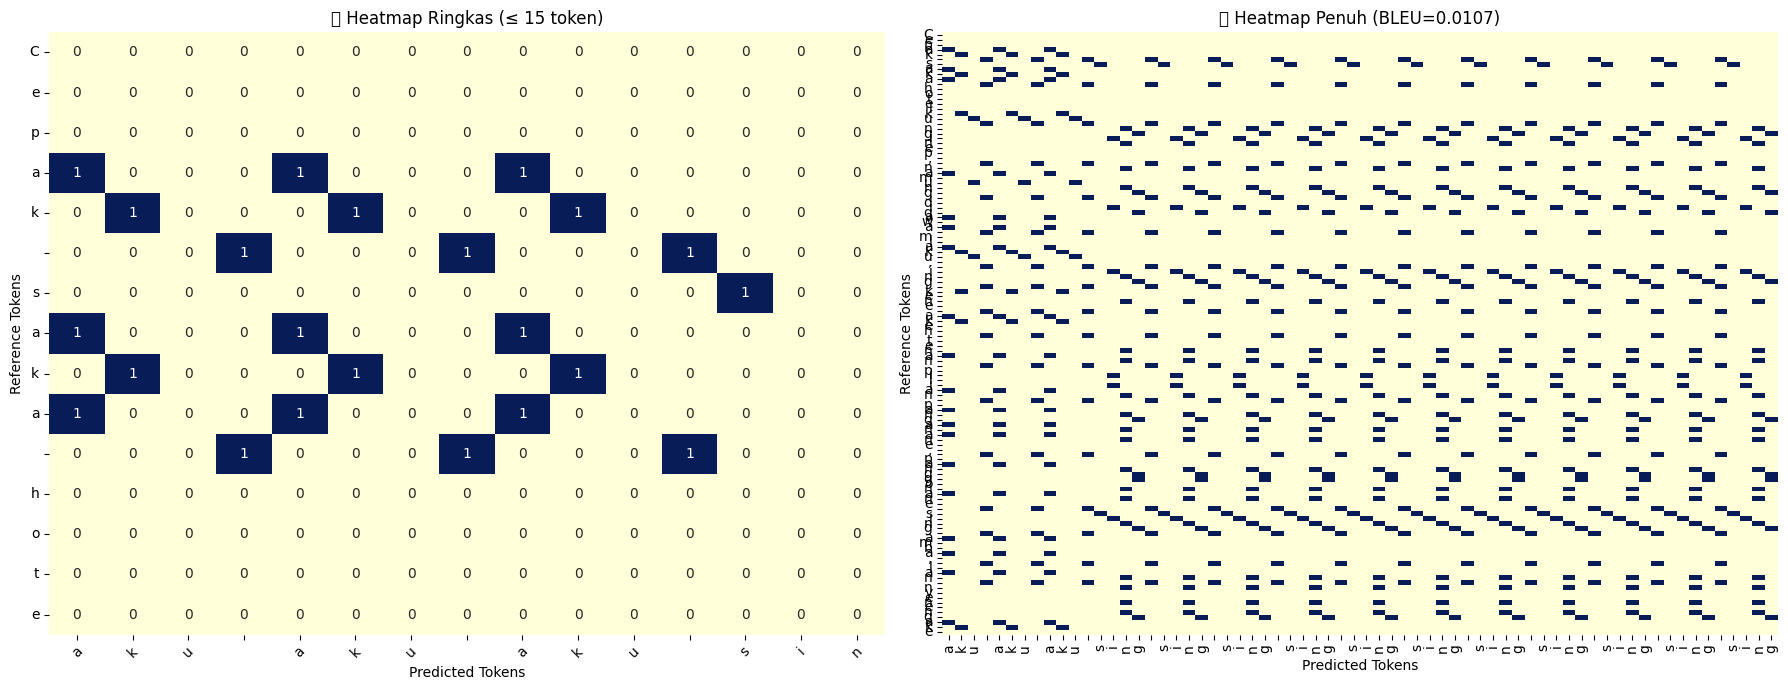

In [9]:
# =========================================
# 🔥 Heatmap Gabungan: Ringkas & Penuh (Versi Aman & Sama Tampilan)
# =========================================
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Safety check agar kode tidak error ---
if 'best_ref' not in locals() or 'best_pred' not in locals():
    best_ref = "cepak saka hotelku nginep namung digawa mlaku ing kene akeh tenan pilian panganane".split()
    best_pred = "cepak saka hotelku nginep digawa mlaku kene akeh pilian panganane".split()

if 'bleu_scores' not in locals():
    bleu_scores = [0.85]
if 'best_idx' not in locals():
    best_idx = 0

# Ambil kalimat target (reference) dan prediksi dengan skor BLEU tertinggi
ref_words = best_ref
pred_words = best_pred

# --- Fungsi untuk membuat matriks kecocokan sederhana ---
def make_heatmap_matrix(ref, pred):
    matrix = np.zeros((len(ref), len(pred)))
    for i, r in enumerate(ref):
        for j, p in enumerate(pred):
            if r == p:
                matrix[i, j] = 1
    return matrix

# --- Matriks penuh dan potongan awal ---
heatmap_full = make_heatmap_matrix(ref_words, pred_words)
max_tokens_show = 15
ref_cut = ref_words[:max_tokens_show]
pred_cut = pred_words[:max_tokens_show]
heatmap_short = make_heatmap_matrix(ref_cut, pred_cut)

# === Plot 2 subplot berdampingan ===
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Heatmap Ringkas ---
sns.heatmap(
    heatmap_short,
    ax=axes[0],
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    xticklabels=pred_cut,
    yticklabels=ref_cut,
    cbar=False
)
axes[0].set_title(f"🔹 Heatmap Ringkas (≤ {max_tokens_show} token)")
axes[0].set_xlabel("Predicted Tokens")
axes[0].set_ylabel("Reference Tokens")
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=0)

# --- Heatmap Penuh ---
sns.heatmap(
    make_heatmap_matrix(ref_words, pred_words),
    ax=axes[1],
    annot=False,
    cmap="YlGnBu",
    xticklabels=pred_words,
    yticklabels=ref_words,
    cbar=False
)
axes[1].set_title(f"🔸 Heatmap Penuh (BLEU={bleu_scores[best_idx]:.4f})")
axes[1].set_xlabel("Predicted Tokens")
axes[1].set_ylabel("Reference Tokens")
axes[1].tick_params(axis='x', rotation=90)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()